# <font size=5, color = 'black'> Notes </font>

Author: Huan Q. Bui

Affiliation: Fermi1 experiment at Zlabs, MIT
             
PI: Professor Martin Zwierlein

First updated: May 4, 2023

Last updated: May 4, 2023

To do:
- Hyperfine structure vs magnetic field calculator 

# <font size=5, color='black'> Setting up </font>

In [1]:
# imports
import glob
import json
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import os
import scipy
from scipy.optimize import fsolve
from scipy.fft import fft, fftfreq
from scipy.integrate import trapezoid
from scipy.signal import savgol_filter
import pandas as pd

In [75]:
# constants
ABSORPTION_LIMIT = 5.0
SPECIAL_CHARACTERS = "!@#$%^&*()-+?_=,<>/"

# physics constants
hbar = 1.05457182*10**(-34) # Js
me = 9.1093837015e-31    # electron mass
mn = 1.67493e-27         # neutron mass
eC = 1.60218e-19         # electric charge
muB = eC*hbar/(2*me)     # Bohr magneton

# Lithium constants
mLi6 = 9.9883414*10**(-27) # kg
Li6D2Gamma = 5.8724e6 # Hz Note that this is NOT angular freq
Li6D2lambda0 = 670.977338*10**(-9) # meters
Li6D2sigma0 = 3*(Li6D2lambda0)**2/(2*np.pi)
Li6Ahf_s12 = 152.1368407e6  # This is NOT angular freq
Li6Bhf_s12 = 0
Li6Ahf_p12 = 17.386e6 # Hz
Li6Bhf_p12 = 0
Li6Ahf_p32 = -1.155e6 # Hz
Li6Bhf_p32 = -0.10e6 # Hz
Li6I = 1
Li6gI = -0.0004476540

# Sodium-23 constants
mNa23 = 0.38175403519e25 # kg
Na23D2Gamma = 9.794646e6 # Hz
Na23D2lambda0 = 589.158326415e-9 # meters
Na23D2sigma0 = 3*(Na23D2lambda0)**2/(2*np.pi)
Na23Ahf_s12 = 885.8130644050e6 # Hz
Na23Bhf_s12 = 0e6 # Hz
Na23Ahf_p12 = 94.4413e6 # Hz
Na23Bhf_p12 = 0e6 # Hz
Na23Ahf_p32 = 18.53415e6 # Hz
Na23Bhf_p32 = 2.72430e6 # Hz
Na23I = 3/2
Na23gI = -0.0008046108080

# Potassium-40 constants
mK40 = 39.9639984821*1.6605402e-27 # kg 
K40D2Gamma = 6.03511 # MHz
K40D2lambda0 = 766.700674872173e-9 # meters
K40D2sigma0 = 3*(K40D2lambda0)**2/(2*np.pi)
K40Ahf_s12 = -285.730824e6 # Hz
K40Bhf_s12 = 0
K40Ahf_p12 = -34.52325e6 # Hz
K40Bhf_p12 = 0
K40Ahf_p32 = -7.58510e6 # Hz
K40Bhf_p32 = -3.44590e6 # Hz
K40I = 4
K40gI = 0.00017649034


# <font size=5, color='black'> Atomic Physics Tools </font>

##  <font size=3, color=#399FD5>Numerical Zeeman Effect Calculator</font>

In [76]:
# helper functions
def A_hfs(J, I, mj, mi, mjj, mii):
    Ahfs = 0
    if (mj == mjj) and (mi == mii):
        Ahfs = mj*mi
    elif (mj == mjj + 1.0) and (mi == mii - 1.0):
        Ahfs = (1/2)*np.sqrt((J+mj)*(J-mj+1)*(I-mi)*(I+mi+1))
    elif (mj == mjj - 1.0) and (mi == mii + 1.0): 
        Ahfs = (1/2)*np.sqrt((J-mj)*(J+mj+1)*(I+mi)*(I-mi+1))
    else:
        Ahfs = 0
    return Ahfs

def B_hfs(J, I, mj, mi, mjj, mii):
    # reference: N. Ramsey's Molecular Beams... some Appendix, I believe
    Bhfs = 0
    if (mj == mjj) and (mi == mii):
        Bhfs = (1/2)*(3*mi**2-I*(I+1))*(3*mj**2-J*(J+1))
    elif (mj == mjj - 1) and (mi == mii + 1):   
        Bhfs = (3/4)*(2*mjj-1)*(2*mii+1)*np.sqrt((J+mjj)*(J-mjj+1)*(I-mii)*(I+mii+1))
    elif mj == mjj + 1 and mi == mii - 1:
        Bhfs = (3/4)*(2*mjj+1)*(2*mii-1)*np.sqrt((J-mjj)*(J+mjj+1)*(I+mii)*(I-mii+1))
    elif mj == mjj - 2 and mi == mii + 2 :  
        Bhfs = (3/4)*np.sqrt((J+mjj)*(J+mjj-1)*(J-mjj+1)*(J-mjj+2)*(I-mii)*(I-mii-1)*(I+mii+1)*(I+mii+2))
    elif mj == mjj + 2 and mi == mii - 2:
        Bhfs = (3/4)*np.sqrt((J-mjj)*(J-mjj-1)*(J+mjj+1)*(J+mjj+2)*(I+mii)*(I+mii-1)*(I-mii+1)*(I-mii+2))
    else:
        Bhfs = 0

    if (2*I*(2*I-1)*J*(2*J-1)) != 0:
        Bhfs = Bhfs/(2*I*(2*I-1)*J*(2*J-1))
    return Bhfs

def mag(B, J, L, S, mj, mi, mjj, mii, gI):
    gL = 1 - me/mn           # gyro magnetic factor of the orbital
    gS = 2.0023193043622     # electron spin g-factor
    gJ = gL*(J*(J+1)-S*(S+1)+L*(L+1))/(2*J*(J+1)) + gS*(J*(J+1)+S*(S+1)-L*(L+1))/(2*J*(J+1)) # verified, correct :)
    
    mag = 0
    if mj == mjj and mi == mii:
        mag = (muB/hbar)*(gJ*mj + gI*mi)*B*1e-4 # B is in Gauss, need to convert to Tesla
    else:
        mag = 0

    return mag/(2*np.pi) # return answer in Hz

In [77]:
# zeeman splitting calculator
def zeeman_splitting_calculator(J, I, gI, L, S, B_main, B_start, B_end, num_B, Ahf, Bhf = 0, 
                                plotting = True, highlight_HF_states = [0,0], plot_range = None, 
                                single_B_field_calc_mode = False, print_field_sensitivity_between = [1,2],
                                search_mode = False, splitting = 0, splitting_between_states = [0,0]):

    B_start = min(B_start, B_end)
    B_end = max(B_start, B_end)
    if num_B >= 20:
        B_fields = np.linspace(B_start, B_end, num_B)
        if B_main < max(B_fields) and B_main > min(B_fields):
            B_fields = np.append(B_fields, B_main)
            B_fields = np.sort(B_fields)
        else:
            print('The variable "B_main" is not in B fields!')
            return 0        
    else:
        print('Number of points must exceed 20!')
        return 0
    
    # possible Js
    possible_Js = np.arange(abs(L-S), abs(L+S)+1, 1)
    if J > max(possible_Js) or J < min(possible_Js):
        print('Invalid J!')
        return 0
    mJ = np.linspace(-J, J, int(2*J+1))
    mI = np.linspace(-I, I, int(2*I+1))

    # now make a basis:
    basis = [] # which is the set {[mj, mi]}
    for mj in mJ:
        for mi in mI:
            basis.append([mj, mi])
    size = len(basis)
    H = np.empty((size,size))
    list_of_freqs = [ ]

    # generate the zeeman Hamiltonian and diagonalize it 
    for b in B_fields:
        for r in range(size):
            mj = basis[r][0]
            mi = basis[r][1]
            for c in range(size):
                mjj = basis[c][0]
                mii = basis[c][1]
                H[r,c] = Ahf * A_hfs(J, I, mj, mi, mjj, mii) + Bhf * B_hfs(J, I, mj, mi, mjj, mii) + mag(b, J, L, S, mj, mi, mjj, mii, gI)
        freqs, eigenvectors = np.linalg.eig(H)
        freqs = freqs * 1e-6
        list_of_freqs.append(freqs)

    # Plotting and returning statistics:
    list_of_freqs = np.array(list_of_freqs)
    list_of_freqs = np.sort(list_of_freqs, axis=1)    
    highlight_HF_states = np.array(highlight_HF_states)
    if plotting:
        for s in range(size):
            plt.plot(B_fields, list_of_freqs[:,s], linewidth = 1, color='red')
        if highlight_HF_states.all() in np.arange(1, size+1,1):
            for state in highlight_HF_states:
                plt.plot(B_fields[np.where((B_fields == B_main))[0][0]:], 
                         list_of_freqs[np.where((B_fields == B_main))[0][0] : , state-1], linewidth = 1.5 , color = 'black')
        if plot_range is not None:
            plt.ylim(plot_range)
        plt.xlabel('Magnetic field (G)')
        plt.ylabel('Energy shift (MHz)')
        plt.grid()
        plt.show()   

    # Compute relevant statistics:
    if single_B_field_calc_mode:
        print('Frequency spacings (MHz), from low to high in energy, at ' + str(B_main) +  ' G:')
        freqs = list_of_freqs[np.where(B_fields == B_main)[0][0]]
        for i in range(len(freqs)-1):
            print("{:.4f}".format(freqs[i+1] - freqs[i]))    
        print(' ')    
        # Field sensitivities:
        print('Field sensititivies (MHz per G), from low to high in energy, at ' + str(B_main) + ' G:')
        freqs_next = list_of_freqs[np.where(B_fields == B_main)[0][0] + 1]
        freqs_diff = freqs_next - freqs
        Bs_diff = B_fields[np.where(B_fields == B_main)[0][0] + 1] - B_fields[np.where(B_fields == B_main)[0][0]]
        for i in range(len(freqs)):
            print("{:.3f}".format(freqs_diff[i] / Bs_diff))  
        print(' ')

        # Next, calculate the difference between in energy between the two states:
        lower_state  = list_of_freqs[ : , print_field_sensitivity_between[0]-1]
        higher_state = list_of_freqs[ : , print_field_sensitivity_between[1]-1]
        differential_shift =  higher_state - lower_state
        # take derivative:
        dfdB = np.diff(differential_shift)/np.diff(B_fields)
        print( 'Field sensitivity, df'+str(print_field_sensitivity_between[1])+str(print_field_sensitivity_between[0])+' by dB:')   
        print("{:.4f}".format(dfdB[np.where((B_fields == B_main))[0][0]]) + ' MHz per G')

    # Search for B_field that matches splitting:
    if search_mode:
        state_A_freqs = list_of_freqs[ : , splitting_between_states[0]-1]
        state_B_freqs = list_of_freqs[ : , splitting_between_states[1]-1]
        AB_freq_differences = np.abs(state_B_freqs - state_A_freqs - splitting) # assuming no weird crossings...
        AB_freq_diff_min_index = np.argmin(AB_freq_differences)

        print(' ')
        print('Closest B field (G): ' + "{:.2f}".format(B_fields[AB_freq_diff_min_index]))
        print('Splitting Error (MHz): ' + "{:.5f}".format( state_B_freqs[AB_freq_diff_min_index] - state_A_freqs[AB_freq_diff_min_index] - splitting ))

        #TODO: add warning is closest B field is at the edge of the B range, since this indicates search fails:
        #TODO: printout B_error

    return 

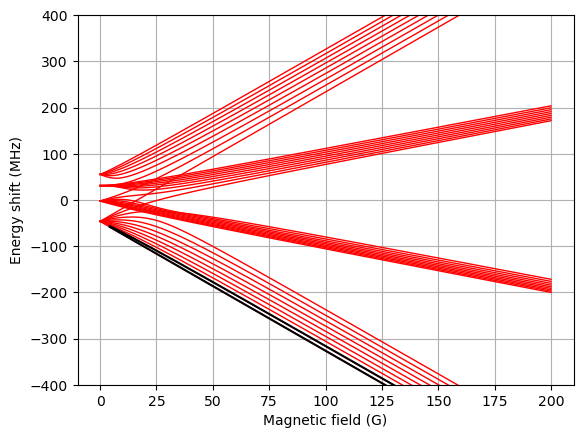

 
Closest B field (G): 200.00
Splitting Error (MHz): -71.61904+0.00000j


In [79]:
# Zeeman shifts and field sensitivities at HF

B_start = 0
B_end = 200
B_main = 4.32 # G
num_B = 1000

# Careful what you type in here!
Ahf = K40Ahf_p32
Bhf = K40Bhf_p32
L = 1
S = 1/2
J = 3/2
I = K40I
gI = K40gI

zeeman_splitting_calculator(J, I, gI, L, S, B_main, B_start, B_end, num_B, Ahf, Bhf, 
                            plotting = True, highlight_HF_states = [1,2], plot_range = [-400, 400], 
                            single_B_field_calc_mode = False, print_field_sensitivity_between = [1,2],
                            search_mode = True, splitting = 82.7145, splitting_between_states = [1,2])